# Ingesting CZO WOF data - from CZO BGC Workshop
## After copying WSDL URL from CZO vizer from an asset
Using "ioos" conda env.   
9/28/2015

### Import packages, set up configurations, and define helper functions

In [1]:
%matplotlib inline
import datetime
import pytz
import pandas as pd
import ulmo
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
import folium

In [2]:
# For Folium map
def inline_map(map, height=500):
    """
    Folium inline, interactive map using Leaflet.
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    iframe = '<iframe srcdoc="{srcdoc}" style="width: 100%%; height: %dpx; border: none"></iframe>' % height
    return HTML(iframe.format(srcdoc=map.HTML.replace('"', '&quot;')))

In [3]:
def create_tsdf(gval, variable_name):
    # Create a clean timeseries list of (dt,val) tuples, show the last 2 entries
    tsdt_tuplst = [(ulmo.util.convert_datetime(valdict['datetime']), float(valdict['value']))
                   for valdict in gval['values']]
    # Ingest into a Pandas Dataframe
    dt, val = zip(*tsdt_tuplst)
    df = pd.DataFrame({'date-time':dt, variable_name:val})
    df.set_index('date-time', inplace=True)
    return df

### Select the CZO and site, and pull in site metadata

In [32]:
# Copied from the S. Sierra vizer, from an asset's infowindow title url
vizer_ss_wofurl = "http://water.sdsc.edu/czo_merced/REST/waterml_1_1.svc/siteinfo?location=czo_merced:UppBull_Met"
wsdlurl = vizer_ss_wofurl.split("REST")[0] + "cuahsi_1_1.asmx?WSDL"
#wsdlurl = "http://water.sdsc.edu/czo_merced/cuahsi_1_1.asmx?WSDL"

In [33]:
#sitecd = 'WCC019'
#sitecd_arg = 'CRBCZO:'+sitecd
sitecd_arg = vizer_ss_wofurl.split('=')[-1]
czocd, sitecd = sitecd_arg.split(':')
sitecd_arg, czocd, sitecd

('czo_merced:UppBull_Met', 'czo_merced', 'UppBull_Met')

In [34]:
# Pull in site information from the CZO Data CUAHSI WaterOneFlow data services
site1info = ulmo.cuahsi.wof.get_site_info(wsdlurl, sitecd_arg)
# List the variable codes used
site1info['series'].keys()

['czo_merced:winddirection6',
 'czo_merced:Snowdepth3',
 'czo_merced:snowwaterequivalent4',
 'czo_merced:relativehumidity1',
 'czo_merced:windspeed5',
 'czo_merced:radiation7',
 'czo_merced:Temperature2']

In [35]:
# Explore one variable ("series")
varcd = 'Temperature2'
varcd_arg = czocd+':'+varcd

site1info['series'][varcd_arg]

{'variable': {'code': 'Temperature2',
  'data_type': 'Average',
  'general_category': 'Hydrology',
  'id': '558',
  'name': 'Temperature',
  'no_data_value': '-9999',
  'sample_medium': 'Not Relevant',
  'speciation': 'Not Applicable',
  'time': {'interval': '1',
   'is_regular': True,
   'units': {'abbreviation': 'hr',
    'code': '103',
    'name': 'hour',
    'type': 'Time'}},
  'units': {'abbreviation': 'degC',
   'code': '96',
   'name': 'degree celsius',
   'type': 'Temperature'},
  'value_type': 'Field Observation',
  'vocabulary': 'czo_merced'},
 '{http://www.cuahsi.org/water_ml/1.1/}method': {'method_description': 'No method specified',
  'method_id': '18'},
 '{http://www.cuahsi.org/water_ml/1.1/}quality_control_level': {'definition': 'Derived products',
  'quality_control_level_code': '2',
  'quality_control_level_id': '2'},
 '{http://www.cuahsi.org/water_ml/1.1/}source': {'citation': 'Unknown',
  'organization': 'UCMerced',
  'source_description': 'czo',
  'source_id': '2'},

### Plot site on a map, for reference

In [36]:
# Text/HTML content for marker popup
popup_str = '<b>%s</b>' % site1info['name']
#popup_str += 'A %s / %s Site<br>' % (SiteRelatedSF['SamplingFeatureTypeCV'],
#                                    SiteRelatedSF['Site']['SiteTypeCV'])
#popup_str += 'SamplingFeatureUUID:<br>%s' % SiteRelatedSF['SamplingFeatureUUID']

# extract lat & lon
lat = float(site1info['location']['latitude'])
lon = float(site1info['location']['longitude'])

In [37]:
mapheight = 300
map = folium.Map(width=500, height=mapheight, location=[lat, lon], zoom_start=6)
map.simple_marker([lat, lon], popup=popup_str)
inline_map(map, mapheight+10)

### Request and parse time series for the selected variable

In [38]:
site1var1_gval = ulmo.cuahsi.wof.get_values(wsdlurl, sitecd_arg, varcd_arg)

In [39]:
# Set a nice, user-friendly variable name string
site1variable = site1var1_gval['variable']
unitsabbrev = site1variable['units']['abbreviation']
variable_name = "%s, %s (%s)" % (site1variable['name'], unitsabbrev, site1variable['value_type'])

In [40]:
# Ingest into a Pandas Dataframe
ts_df = create_tsdf(site1var1_gval, variable_name)
ts_df.tail(10)

,"Temperature, degC (Field Observation)"
date-time,
2011-09-30 15:00:00,17.0150
2011-09-30 16:00:00,15.9075
2011-09-30 17:00:00,14.5875
2011-09-30 18:00:00,12.6925
2011-09-30 19:00:00,11.4750
2011-09-30 20:00:00,11.0150
2011-09-30 21:00:00,10.9400
2011-09-30 22:00:00,11.1650
2011-09-30 23:00:00,10.9875


### Plot the time series data

In [41]:
# For matplotlib plots, including time series plots
matplotlib.style.use('ggplot')

**Datetime in request vs response:** Note that *dt0* passed as argument to get_values was naive, had no timezone information. The response datetime strings do have a timezone offset. The first datetime values in this response (*site1var1_ts[:2]*) make it clear that the WOF server interpreted *dt0* as being in *local* time (the timezone used in the WOF database and server), which is Eastern in this case.

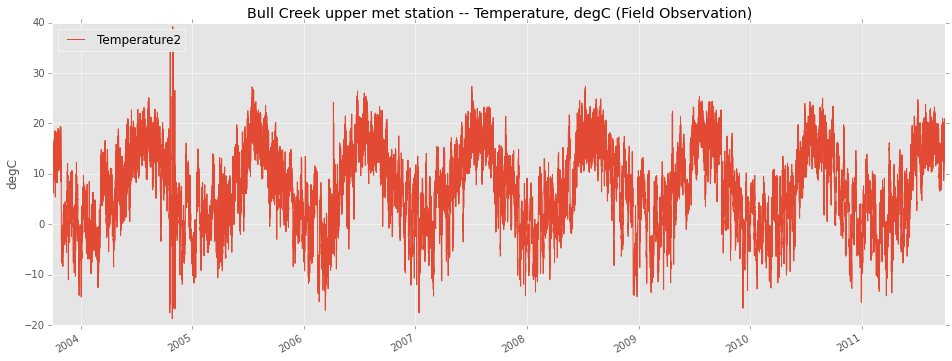

In [45]:
# Nicer plot
plt.figure(figsize=(16,6))

df = ts_df
#ax = df['Radiation, incoming, W/m2 (Field Observation)'].plot(style='o-', label=varcd)
ax = df[variable_name].plot(style='-', label=varcd)
ax.set_ylabel(unitsabbrev)

ax.legend(loc=2)
ax.xaxis.grid(True, which="major")
ax.set_xlabel('')
ax.set_title(site1info['name'] + ' -- ' + variable_name);

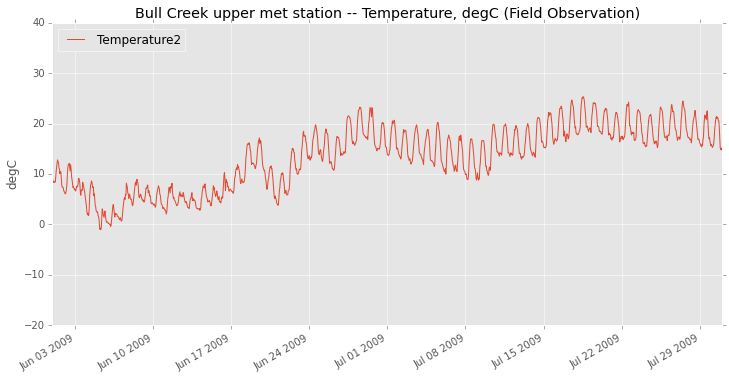

In [47]:
plt.figure(figsize=(12,6))

ax = df[variable_name].plot(style='-', label=varcd)
ax.set_ylabel(unitsabbrev)
#ax.set_ylim([-10, 1200])
        
ax.legend(loc=2)
ax.xaxis.grid(True, which="major")
ax.set_xlabel('')
ax.set_xlim([datetime.datetime(2009, 6, 1), datetime.datetime(2009, 7, 31)])
ax.set_title(site1info['name'] + ' -- ' + variable_name);

#### Aggregate by day, as mean or min

In [49]:
bydateagg_df = df.groupby(df.index.date)[variable_name].min()

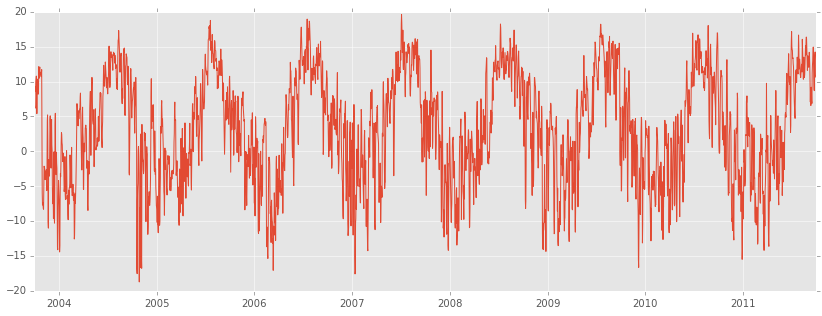

In [51]:
bydateagg_df.plot(figsize=(14,5))

In [61]:
bydaterange_df = df.groupby(df.index.date)[variable_name].max() - df.groupby(df.index.date)[variable_name].min()

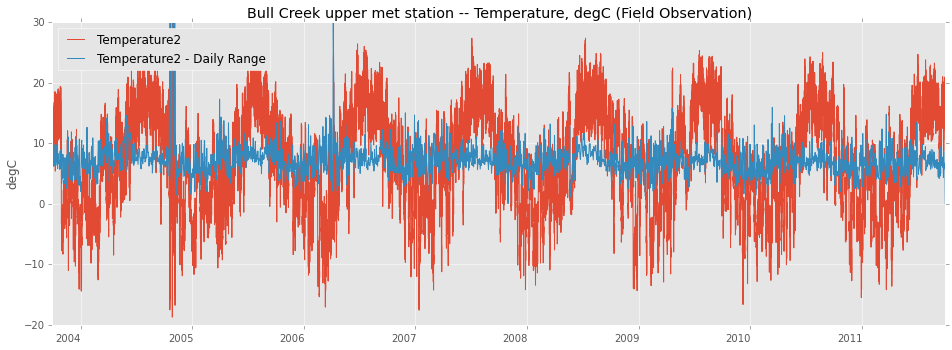

In [63]:
plt.figure(figsize=(16,6))

df = ts_df
ax = df[variable_name].plot(style='-', label=varcd)
ax.set_ylabel(unitsabbrev)

bydaterange_df.plot(style='-', label=varcd + " - Daily Range",
                    ax=ax)
ax.legend(loc=2)
ax.xaxis.grid(True, which="major")
ax.set_xlabel('')
ax.set_ylim([-20, 30])
ax.set_title(site1info['name'] + ' -- ' + variable_name);

### Plot a more processed view: daily temperature range, by  day of year

In [64]:
bydaterange_df2 = pd.DataFrame(bydaterange_df)

In [70]:
bydaterange_df2.index = pd.to_datetime(bydaterange_df2.index)

In [71]:
bydaterange_df2.index

DatetimeIndex(['2003-10-01', '2003-10-02', '2003-10-03', '2003-10-04',
               '2003-10-05', '2003-10-06', '2003-10-07', '2003-10-08',
               '2003-10-09', '2003-10-10', 
               ...
               '2011-09-22', '2011-09-23', '2011-09-24', '2011-09-25',
               '2011-09-26', '2011-09-27', '2011-09-28', '2011-09-29',
               '2011-09-30', '2011-10-01'],
              dtype='datetime64[ns]', length=2923, freq=None, tz=None)

In [72]:
bydaterange_df2['dayofyear'] = bydaterange_df2.index.dayofyear

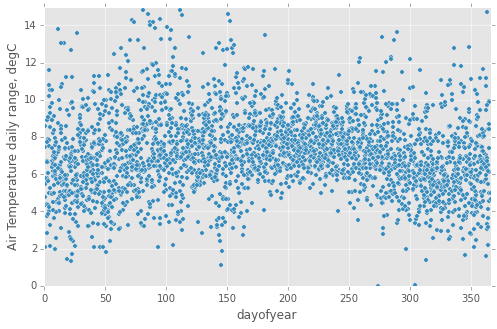

In [77]:
ax = bydaterange_df2.plot(kind='scatter', x='dayofyear', y=variable_name, 
             xlim=[0,366], figsize=(8,5))
ax.set_ylim([0, 15])
ax.set_ylabel('Air Temperature daily range, degC')
#ax.set_title(VariableCode);